# MNIST classification
---

In [1]:
import torch
torch.__version__

'1.7.1'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

## 1. Define Dataloaders

In [5]:
training_epochs = 5   
batch_size = 100     
learning_rate = 1e-4 # 국룰 : 0.0001

transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(0.5, 0.5)])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

## TODO: define testset and testloader
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                         shuffle=False, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)  # 28x28

torch.Size([100, 1, 28, 28])


In [13]:
## plotting function
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## 2. Define Network

#### ✔️ Single layer Network

In [5]:
class NetforMNIST_linear(nn.Module):
    def __init__ (self):
        super(NetforMNIST_linear, self).__init__()
        ## TODO: define linear layer (in_ch: 1*28*28, out_ch, 10)
        self.fc1 = nn.Linear(1 * 28 * 28, 10)
        ##
        
    def forward(self, x):
        ## TODO: run network
        # x: b x (c x h x w)
        x = x.view(x.size(0), -1) # input이 이미지이기 때문에 flatten 시킨 후 FC
        x = self.fc1(x)
        ##
        return x

#### ✔️ Convolutional Network
![convnet](./resources/mnist.png "Variable")
*kernel size for conovlution layer is 5x5*

In [9]:
class NetforMNIST(nn.Module):
    def __init__ (self):
        super(NetforMNIST, self).__init__()
        ## TODO: define layers as the figure above
        self.conv1 = nn.Conv2d(1, 6, 5, padding=0) # 1x28x28 -> 6x24x24 
        self.conv2 = nn.Conv2d(6, 16, 5)           # 6x12x12 -> 16x8x8
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 16x4x4 -> 120
        self.fc2 = nn.Linear(120, 84)         # 120    -> 84
        self.fc3 = nn.Linear(84, 10)          # 84     -> 10
        ##
        
    def forward(self, x):
        ## TODO: run network
        # Subsampleing layer in the figure: Max pooling layer with 2x2 window
        # ReLU activation layer after every layer except the last one
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        ## x -> [B, C, H, W] -> [B, C * H * W]
        x = x.view(x.size(0), -1) # flatten되버림 (16x5x5 -> 120)
#         x = x.view(-1, x.size(2)*x.size(3)) # 같은 결과
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # softmax 사용안함 -> loss에서 logit형태로 받아서 사용함, loss 함수에 softmax가 들어있음
        ##
        
        return x

In [10]:
# net = NetforMNIST_linear().to(torch.device('cuda'))
# (shall) > CUDA_VISIBLE_DEVICES = 1   # > CUDA_VISIBLE_DEVICES = 0,1 로도 가능
net = NetforMNIST().to(torch.device('cuda')) # .to(torch.device('cuda:0')) 0번 GPU 지정해서 쓸 때 사용
                                             # shall에서 1번 gpu로 지정하면 주피터에서 .to(torch.device('cuda:0')) 실행해도 
                                             # 1번 gpu가 실행됨. 주피터에서는 1번 gpu만 보이기 때문에

## 3. Define Loss Function

In [19]:
CSE = nn.CrossEntropyLoss() 
optim = torch.optim.Adam(net.parameters(), lr=learning_rate) # 국룰 : Adam, lr = 1e-4 
# optim = torch.optim.Adam(dict(net.parameters()), lr=learning_rate) # 응용 : param을 골라서 넣어줄 수 있다

## 4. Train Network

In [20]:
for epoch in range(training_epochs):
    running_loss = 0.0
    ## images, label = dataiter.next()
    ## data = dataiter.next()
    
    for i, data in enumerate(trainloader):
        inputs, labels = data # tuple형태의 리스트 (images, label)
        ## TODO
        # data to GPU
        inputs = inputs.to(torch.device('cuda')) # .cuda() 보다 torch.device가 더 빠르다
        labels = labels.to(torch.device('cuda'))
        
        # run network
        outputs = net(inputs) # net과 inputs이 cuda여서 outputs도 cuda임
        
        # compute loss
        loss = CSE(outputs, labels)
        
        # compute gradient(1, 2), update network(3)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        ##
        running_loss += loss # 한 epoch을 돌 때 average loss
    print('\r[Epoch {}/{}] loss: {}'.format(epoch, training_epochs, running_loss/(i+1)), end='')
print('\nFinished Training')

[Epoch 4/5] loss: 0.12737827003002167
Finished Training


## Test

In [ ]:
# correct = 0
# total = 0

# for data in testloader:
#     images, labels = data
#     with torch.no_grad(): ##### <- !!!!!! 
#         outputs = net(images.to(torch.device('cuda')))
#         _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels.cuda()).sum()

# print('Accuracy : %d %%' % (100* correct/total))

In [24]:
correct = 0
total = 0
with torch.no_grad(): ##### <- !!!!!! 
                      # forward를 하면 computational graph가 쌓인다 -> backward를 하기위한 사전준비(buffer를 만들고 메모리를 준비)
                      # forward할 때 buffer를 만들지않고 더 빨라짐(메모리 적게먹음) test할때는 꼭 적용
                      # grad compute 안한다고 선언, test할 때는 곱하기랑 더하기만 함
    for data in testloader:
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        #print(outputs.shape)
        #prob = F.softmax(outputs) test할때 activation 여기서 넣으면 prob 계산가능
        
        _, predicted = torch.max(outputs.data, 1) # max값, index
        
        total += labels.size(0) # batch size만 카운트하면 됨, 0번째는 항상 batch임
        correct += (predicted == labels.cuda()).sum()
    
print('Accuracy : %d %%' % (100* correct/total))

Accuracy : 96 %


### Visualization

In [6]:
dataiter = iter(testloader)

(28, 28, 3)


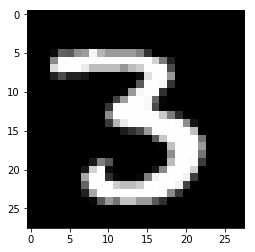

[[4]]


In [23]:
images, labels = dataiter.next()

with torch.no_grad():
    outputs = net(images.to(torch.device('cuda')))
    _, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images, nrow=int(np.sqrt(images.size(0)))))
print(predicted.cpu().numpy().reshape(int(np.sqrt(images.size(0))), -1))